In [1]:
from fish_helpers import *
base = '/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/'
md = Metadata(base)


In [2]:
hybes = [i for i in md.acqnames if 'hybe' in i]
hybe_metadata = md.image_table[md.image_table.acq.isin(hybes)]
hybe_metadata.head()

,Channel,Exposure,FlatField,PixelSize,PlateType,Position,Skip,TimestampFrame,TimestampImage,Triggered,...,XYbeforeTransform,Z,Zindex,acq,df_pos,filename,frame,group,linescan,root_pth
0,FarRed,600,NaN,0.1032,Robs PDMS,Pos1,1,737970.601984,737970.601977,False,...,"[2661.195, 1576.823]",3093.800,1,hybe1_4,0,/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/...,1,Pos1,NaN,Pos0/img_Pos1_000000001_000000000_FarRed_000_0...
1,Orange,600,NaN,0.1032,Robs PDMS,Pos1,1,737970.601984,737970.601986,False,...,"[2661.195, 1576.823]",3093.800,1,hybe1_4,0,/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/...,1,Pos1,NaN,Pos0/img_Pos1_000000001_000000000_Orange_000_0...
2,DeepBlue,50,NaN,0.1032,Robs PDMS,Pos1,1,737970.601984,737970.601990,False,...,"[2661.195, 1576.823]",3093.800,1,hybe1_4,0,/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/...,1,Pos1,NaN,Pos0/img_Pos1_000000001_000000000_DeepBlue_000...
3,FarRed,600,NaN,0.1032,Robs PDMS,Pos1,1,737970.602008,737970.602000,False,...,"[2661.195, 1576.823]",3094.206,2,hybe1_4,0,/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/...,1,Pos1,NaN,Pos0/img_Pos1_000000002_000000000_FarRed_000_0...
4,Orange,600,NaN,0.1032,Robs PDMS,Pos1,1,737970.602008,737970.602010,False,...,"[2661.195, 1576.823]",3094.206,2,hybe1_4,0,/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/...,1,Pos1,NaN,Pos0/img_Pos1_000000002_000000000_Orange_000_0...


In [3]:
posnames = hybe_metadata.Position.unique()

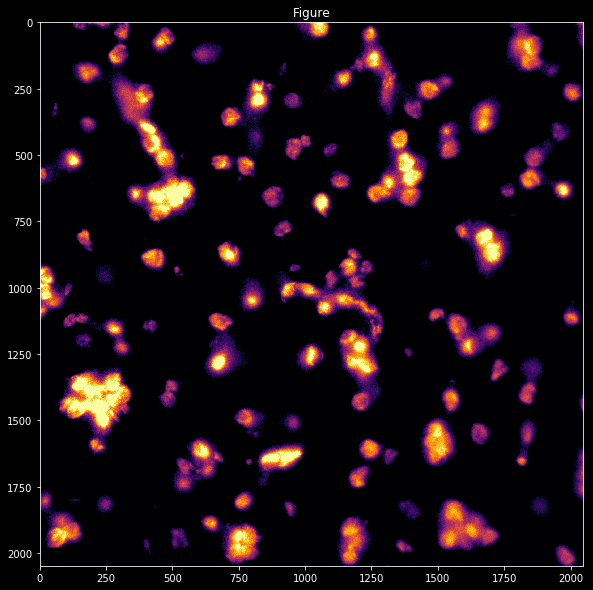

In [7]:
from scipy.ndimage import gaussian_filter
nucstain = [i for i in md.acqnames if 'nucstain' in i]
image = md.stkread(Position='Pos1',Channel='DeepBlue',acq=nucstain[0],zindex=15)[:,:,0].astype('float32')
bkg = gaussian_filter(image,100).astype('float32')
Display(image-bkg,rel_min=75,rel_max=95)

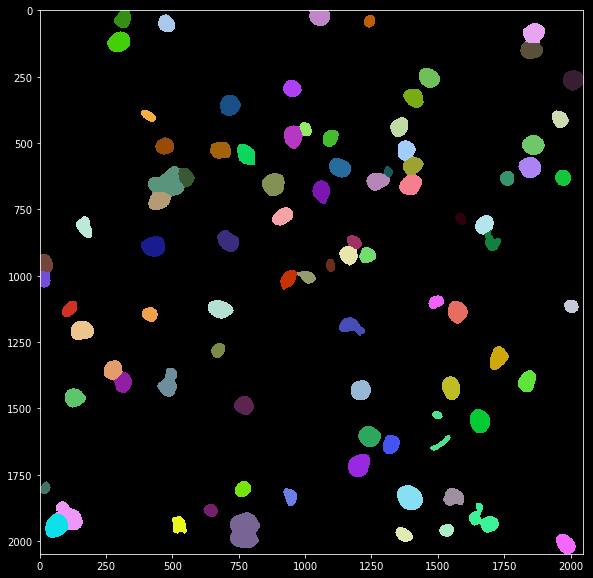

In [10]:
image = md.stkread(Position='Pos1',Channel='DeepBlue',acq='nuclei_mask',zindex=15)[:,:,0]
plt.figure(figsize=[10,10])
plt.imshow(colorize_segmented_image(image))
plt.show()

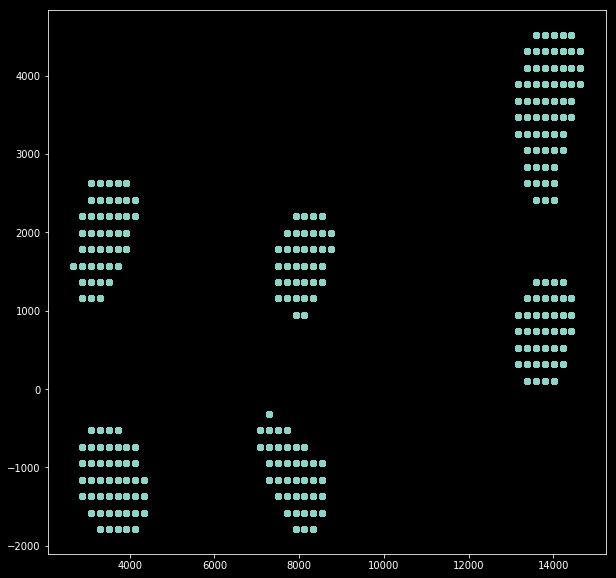

In [68]:
xy = np.stack(hybe_metadata.XY,axis=0)
plt.figure(figsize=[10,10])
plt.scatter(xy[:,0],xy[:,1],s=1)
plt.show()

In [43]:
pixelsize=0.102
cameradirection=[1,1]

xy = np.stack(hybe_metadata.XY,axis=0).astype(int)
mask = (xy[:,0]<6000)&(xy[:,1]<0)
temp_metadata = hybe_metadata[mask]
xy = np.stack(temp_metadata.XY,axis=0).astype(int)
centers = []
for pos in tqdm(temp_metadata.Position.unique()):
    x,y = temp_metadata[temp_metadata.Position==pos].XY.iloc[0].astype(int)
    image = md.stkread(Position=pos,Channel='DeepBlue',acq='nuclei_mask')
    centroids = []
    for region in regionprops(image):
        centroids.append(region.centroid)
    centroids = np.stack(centroids,axis=0)[:,0:2]
    centroids = centroids*pixelsize*cameradirection+(y, x)
    centers.extend(list(centroids))

100%|██████████| 46/46 [02:13<00:00,  2.89s/it]


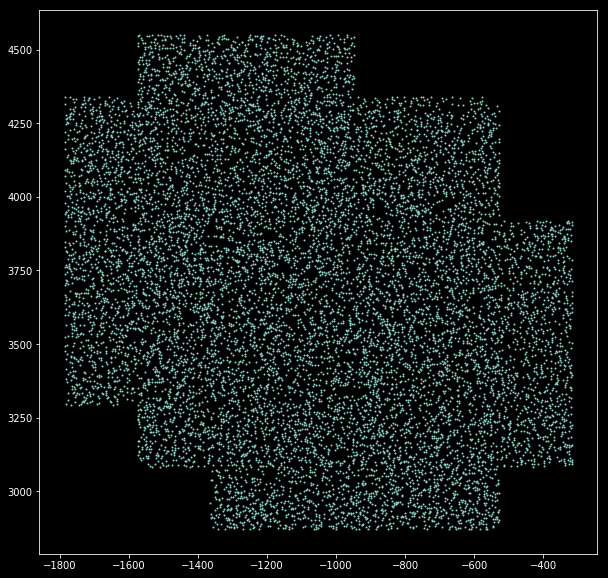

In [44]:
plt.figure(figsize=[10,10])
xy = np.stack(centers,axis=0)
plt.scatter(xy[:,0],xy[:,1],s=1)
plt.show()

In [45]:
xy.shape

(11692, 2)

In [ ]:
from skimage.transform import rescale
from tqdm import tqdm
xy = np.stack(hybe_metadata.XY,axis=0).astype(int)
mask = (xy[:,0]<6000)&(xy[:,1]<0)
temp_metadata = hybe_metadata[mask]
downsample  = 0.1025
border = int(2048*downsample)+1
xy = np.stack(temp_metadata.XY,axis=0).astype(int)
x_min = xy[:,0].min()
x_max = xy[:,0].max()+border
y_min = xy[:,1].min()
y_max = xy[:,1].max()+border
x_range = int(x_max-x_min)
y_range = int(y_max-y_min)
merged = np.zeros((x_range+1,y_range+1))
downsample  = 0.1025
xi = []
yi = []
for i in range(0,border):
    for j in range(0,border):
        xi.append(i)
        yi.append(j)
xi = np.array(xi,dtype=int)
yi = np.array(yi,dtype=int)
for pos in tqdm(temp_metadata.Position.unique()):
    x,y = temp_metadata[temp_metadata.Position==pos].XY.iloc[0].astype(int)
    image = md.stkread(Position=pos,Channel='DeepBlue',acq=nucstain[0],zindex=15)[:,:,0].astype('float32')
    image = rescale(image, downsample, anti_aliasing=False,)
    bkg = gaussian_filter(image,1000/downsample).astype('float32')
    image = image-bkg
    image = image-np.percentile(image.ravel(),50)
    image = image/np.percentile(image.ravel(),90)
    image[image<0] = 0
    image[image>1] = 1
    merged[xi+x-x_min,yi+y-y_min] = image.ravel()
plt.figure(figsize=[10,10])
plt.imshow(merged,cmap='inferno')
plt.show()